### The Goal:
The goal of this project is to write a python function with the following inputs and outputs:

#### Input: 
A quantum circuit containing a diagonal unitary operator $U$, such that $U \Ket{x}_n = e^{2\pi\Theta(x)}\Ket{x}_n$, such that all values of $e^{2\pi\Theta(x)}$ are distinct, a number $d$, such that $2^d \Theta(x) \in \mathbb{Z}$ for each $x$, and a value $t \in [0,1]$ with the promise that there exists only one $x$ such that $e^{2 \pi i t}=e^{2 \pi i \Theta(x)}$. 

#### Output: 
Output $x$. 

In [38]:
## Import necessary libraries
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
import numpy as np
from qiskit.circuit.library import MCXGate
from qiskit.circuit.library import ZGate

In [39]:
## Function to create diagonal unitary 
# Input: A array of length N=2^n entries
from qiskit.circuit.library import Diagonal

def diagonal_unitary_from_array(n, diag_entries,k):
    """
    Create a diagonal unitary matrix from an array of complex entries.

    Parameters:
        n (int): Number of qubits (must satisfy len(diag_entries) == 2^n)
        diag_entries (array-like): Length-2^n complex array specifying diagonal unitary entries

    Returns:
        QuantumCircuit: A circuit implementing the controlled diagonal unitary operator CU^(2^k)
    """
    diag_entries = np.asarray(diag_entries, dtype=complex)
    N = 2 ** n

    if diag_entries.shape[0] != N:
        raise ValueError(f"Length of input array must be 2^{n} = {N}.")

    # Check unitarity: All entries must have modulus 1
    if not np.allclose(np.abs(diag_entries), 1, atol=1e-10):
        raise ValueError("All entries must have magnitude 1 to form a unitary diagonal matrix.")

    # Create the diagonal gate
    diag_gate = Diagonal([l**(2**k) for l in diag_entries])
    controlled_diag_gate = diag_gate.control(1)

    # Wrap in a quantum circuit
    qc = QuantumCircuit(n)
    qc.append(diag_gate, qc.qubits)

    return controlled_diag_gate

### Part 1: Preliminaries.

We start with implementing the preliminaries. This includes the quantum fourier transform and inverse quantum fourier transform, as well as a quantum phase estimator. 

In [40]:
### Implement QFT and inverse QFT
def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name=f"QFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            QFT_circuit.cp(np.pi / (1 << j), q, p)

    return QFT_circuit

def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)

    return inverse_QFT_circuit

Next, we implement a quantum phase estimator. It takes as input a quantum state $\Ket{\Psi}$, an operator $U$ such that $U \Ket{\Psi}=e^{2 \pi i \Theta} \Ket{\Psi}$, and $d \in \mathbb{IN}$, and outputs $\lfloor 2^d \Theta \rfloor$. To start with, we design a function that takes as input a circuit for the controlled $U$ operation for an arbitrary unitary operator $U$ and an integer $k$, and outputs a circuit that implements the circuit $CU^{2^k}$. The simplest way of doing so requires applying the $CU$ operator in sequence $2^k$ times, this circuit has depth $2^k$ however. 

In [41]:
def controlled_U_power(CU,k,n):
    psi = QuantumRegister(size=n, name="Psi")
    control=QuantumRegister(size=1, name="control")
    circuit=QuantumCircuit(control, psi)
    for j in range(2**k):
        circuit.compose(CU, qubits=control[:]+ psi[:], inplace=True)
    return circuit


In [42]:
def quantum_phase_estimator(d,n,diag_entries):
    ## Input: A quantum circuit representing an n qubit operator U, and d, 0. 
    ## Output $\lfloor 2^d \Theta \rfloor$

    theta = QuantumRegister(size=d, name="Theta")
    psi = QuantumRegister(size=n, name="Psi")
    circuit=QuantumCircuit(theta, psi)
    for j in range(d):
        circuit.h(theta[j])
        gate=diagonal_unitary_from_array(n, diag_entries,j)
        circuit.append(gate, [theta[j], *psi])
    # append an IQFT circuit:
    circuit.compose(inverse_quantum_fourier_transform(d), qubits=theta, inplace=True)
    return circuit

### Part 2: Marker for Grover's algorithm. 

Having implemented the preliminaries, we implement an circuit $M$, given the unitary operator $U$, such that:

$$M \Ket{x}_n \Ket{t}_d =\begin{cases} -\Ket{x}_n \Ket{t}_d \text{ if } U \Ket{x}_n=e^{\frac{2 \pi i t}{2^d}} \Ket{x} \\ \Ket{x}_n \Ket{t}_d \text{ otherwise}   \end{cases}$$

This is a Marker oracle which we use for Grover's search

In [55]:
def Marker(d,n,diag_entries):
    x=QuantumRegister(size=n, name = "x")
    t=QuantumRegister(size=d, name="t")
    phase=AncillaRegister(size=d, name="phase")
    z=AncillaRegister(size=1, name="control")
    circuit=QuantumCircuit(x,t,phase,z)
    QPE=quantum_phase_estimator(d,n,diag_entries)
    # We start with copying the phase of U when acting on x on the ancilla qubits.
    circuit.compose(QPE, qubits=[*phase, *x], inplace=True)
    #The next step: the ancilla register phase[i] is set to 1 if phase[i]=t[i] and 0 otherwise:
    #Start with replacing phase[i] with phase[i] + t[i] mod 2
    for i in range(d):
        circuit.cx(t[i], phase[i])
    #flip each gate in phase:
    for i in range(d):
        circuit.x(phase[i])
    # Multicontrolled x gate on z, with phase as controls:
    mcx = MCXGate(num_ctrl_qubits=d)
    circuit.append(mcx, qargs=[*phase, z])
    # Finally: add a phase of (-1) if z is 1, and nothing otherwise:
    circuit.p(np.pi, z) 
    return circuit 

### Part 3: Grover Search.

We implement a circuit for Grover search, with the above designed marker circuit as a marking subcircuit. 

In [167]:
def grover(d,n, diag_entries):
    #takes as input n and a marker circuit, performs grover search on it

    #define the number of rounds:
    T=int(np.round(np.pi/(4*np.arcsin(1/np.sqrt(2**n)))-0.5))
    x=QuantumRegister(size=n, name = "x")
    t=QuantumRegister(size=d, name="t")
    phase=AncillaRegister(size=d, name="phase")
    z=AncillaRegister(size=1, name="control")
    grover=QuantumCircuit(x,t,phase,z)
    #create a marker circuit, and extract the marker registers
    Mark=Marker(d,n,diag_entries)

    #We put the x registers in a uniform superposition
    grover.h(x)
    
    #perform the grover iteration T times:
    for j in range(T):
        grover.barrier()
        grover.compose(Mark, inplace=True)
        grover.h(x)
        grover.x(x)
        mcz = ZGate().control(n-1)
        grover.append(mcz, qargs=[*x])
        grover.x(x)
        grover.h(x)
    return grover
        

### Part 4: Putting it all together and benchmarking.

We start creating $2^n$ random numbers in $\{0,1,\dots, 2^{d}-1\}$. Then, we draw the grover circuit with this as input. 

[0, 1, 2, 3, 4, 5, 6, 7]


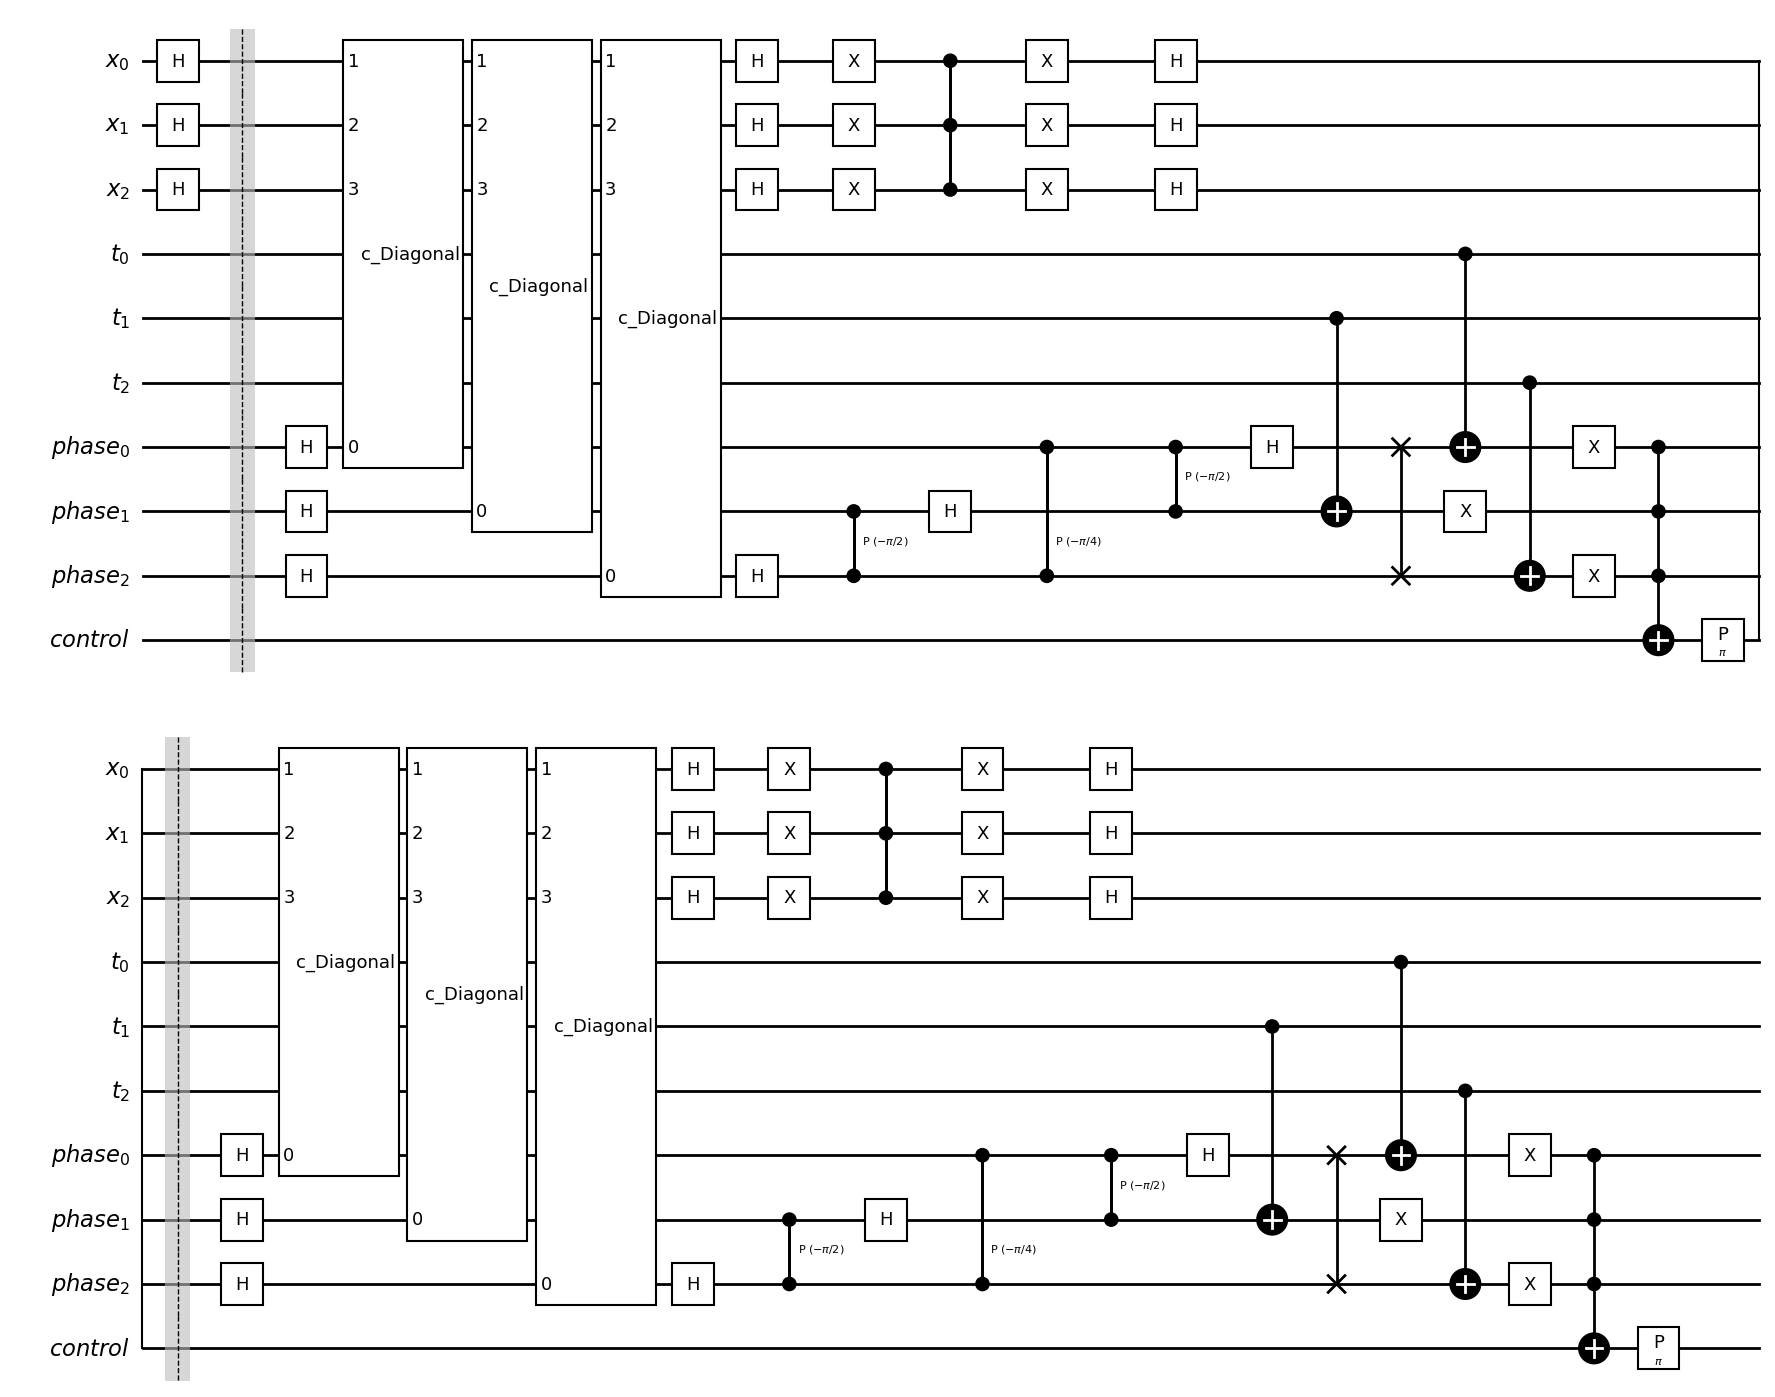

In [168]:
n=3
d=3
#Create 2^n random diagonal entries of bit complexity d. 
N = 2**n
D = 2**d

if N > D:
    raise ValueError("Cannot generate unique random integers: 2^n > 2^d")

# Generate without repetition using choice
random_array =  [i for i in range(2**d)] 
#np.random.choice(D, size=N, replace=False)
print(random_array)
diag_entries=[np.exp(2j * np.pi * num / (2**d)) for num in random_array]
Grover=grover(d,n,diag_entries)
Grover.draw(output="mpl", style="bw")


Now, we suppose we want to find the eigenvector corresponding to the phase $6$. We would need the circuit to find the eigenvector $\Ket{4}$. To do so, we run the circuit on the inputs $\Ket{0} \Ket{6} \Ket{0} \Ket{0}$, and output the final statevector. 

In [172]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.quantum_info import Statevector

x = QuantumRegister(3, 'x')
t = QuantumRegister(3, 't')
phase = QuantumRegister(3, 'phase')
control = QuantumRegister(1, 'control')


# Initialize input state |0>_x |6>_t |0>_phase |0>_control
init_circ = QuantumCircuit(x, t, phase, control)
init_circ.x(t[1])
init_circ.x(t[2])

# Combine initialization + your circuit
full_circuit = init_circ.compose(Grover)

# Simulate the final statevector
initial_sv = Statevector.from_label('0' * 10)  # all-zero state
final_sv = initial_sv.evolve(full_circuit)

# Print the statevector
print(final_sv)


Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


Now, we extract the probability amplitudes for the x registers. 

In [170]:
# Get qubit index positions for x register in the full circuit
x_indices = [full_circuit.qubits.index(q) for q in x]

# Now get the marginal probability distribution over x
prob_dict = final_sv.probabilities_dict(qargs=x_indices)

# Extract probability for x = 6, which corresponds to bitstring '110'
prob_x_6 = prob_dict.get('110', 0.0)
print(f"Probability for x = 6: {prob_x_6:.6f}")


Probability for x = 6: 0.090514


In [171]:
# Get qubit index positions for x register in the full circuit
x_indices = [full_circuit.qubits.index(q) for q in x]

# Marginalize the statevector over the x qubits
prob_dict = final_sv.probabilities_dict(qargs=x_indices)

# Print probabilities for x = 0 to 7
for i in range(8):
    bitstring = format(i, '03b')  # 3-bit binary string for i
    prob = prob_dict.get(bitstring, 0.0)
    print(f"x = {i} : {prob:.6f}")


x = 0 : 0.147097
x = 1 : 0.129576
x = 2 : 0.095090
x = 3 : 0.139285
x = 4 : 0.167299
x = 5 : 0.102903
x = 6 : 0.090514
x = 7 : 0.128236


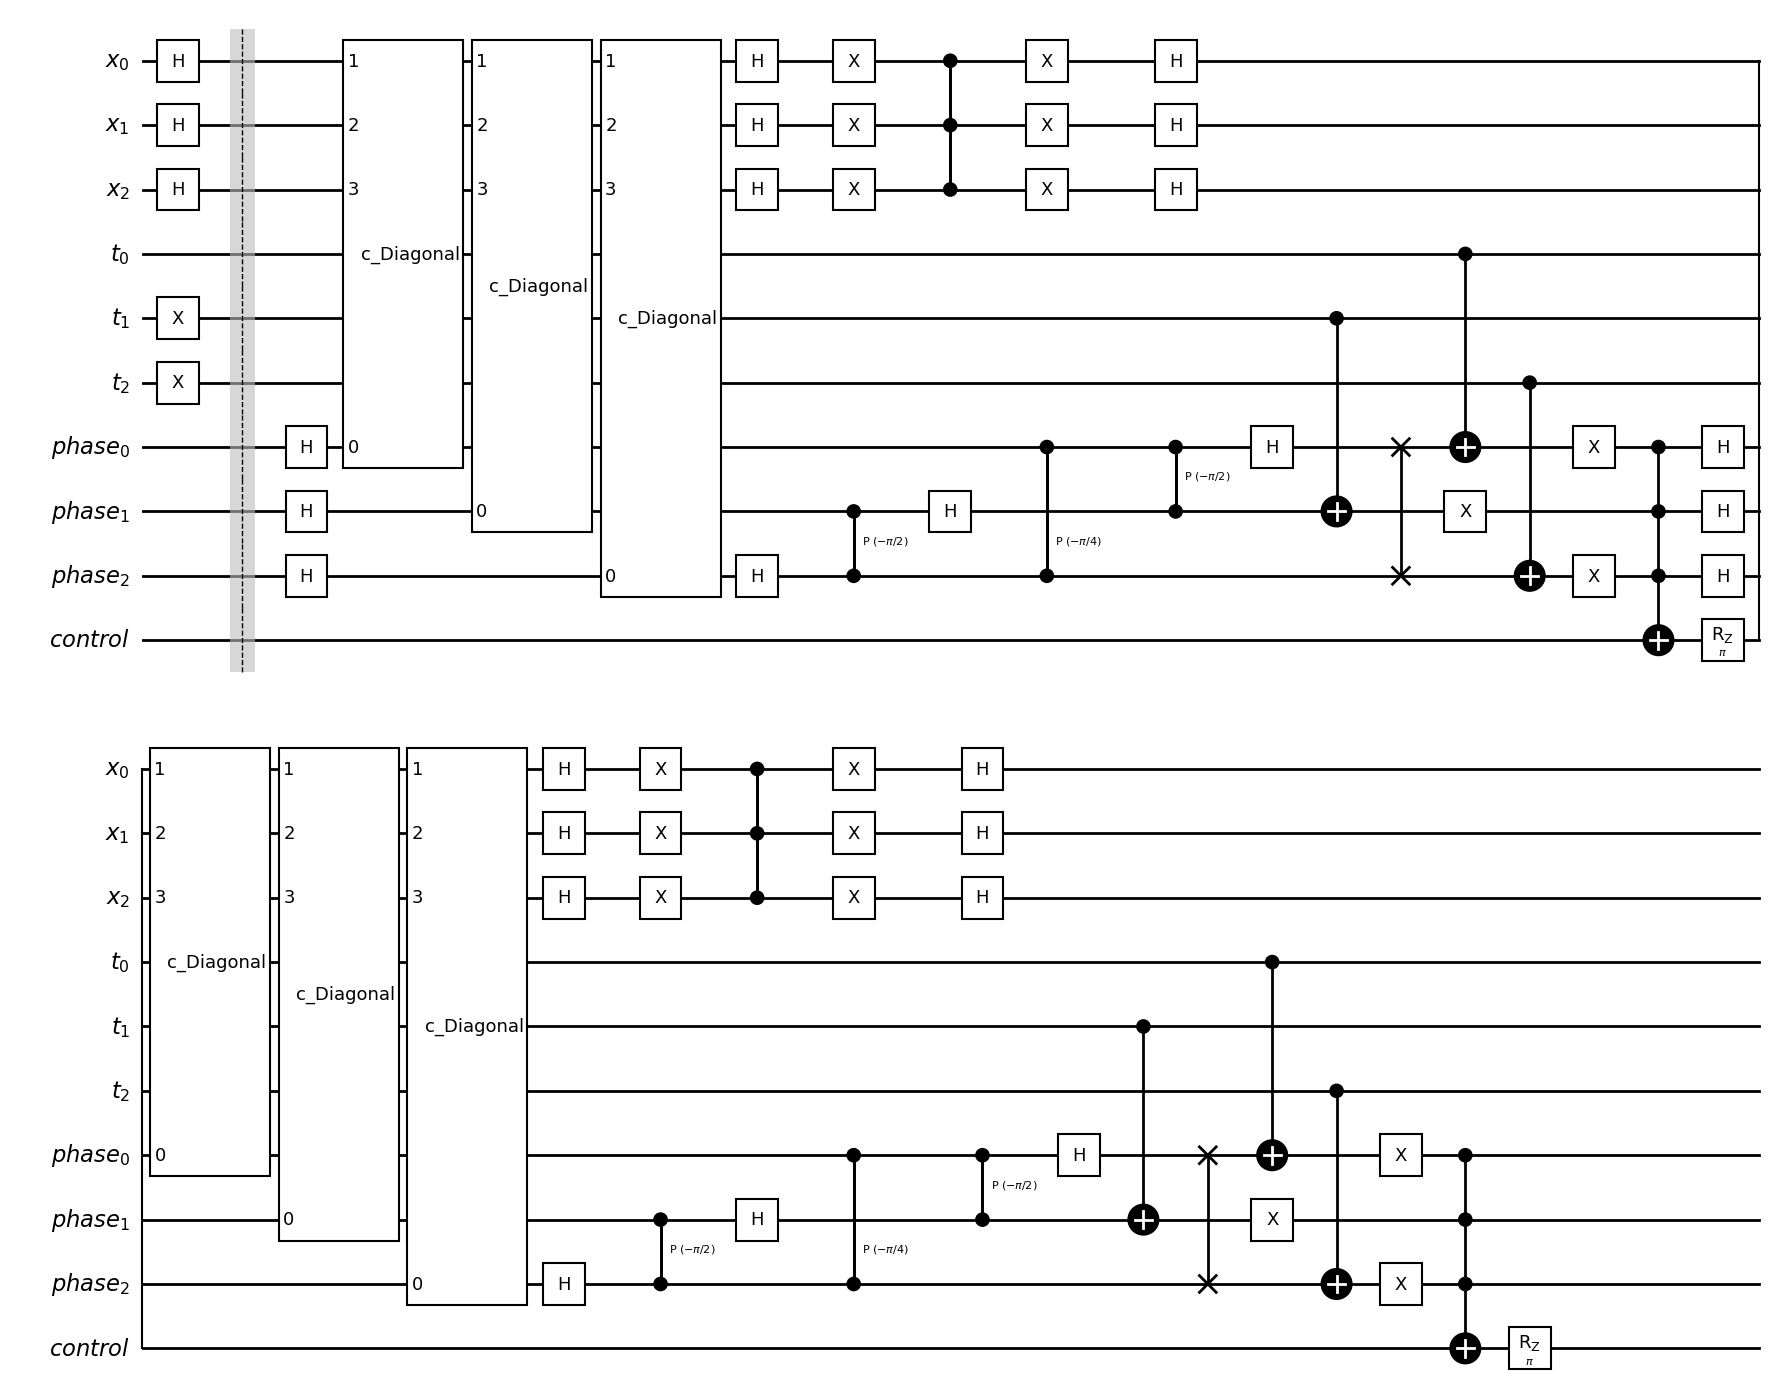

In [49]:
full_circuit.draw(output="mpl", style="bw")

In [149]:
from qiskit.visualization import plot_state_city
from qiskit.quantum_info import Statevector

# Define test parameters
d = 2
n = 2
#diag_entries = [1, 1, 1, 1]  # Marker should apply a -1 phase only when x=2 (binary 10)
diag_entries = [np.exp(2j * np.pi * x / 2**d) for x in range(2**n)]
# Create the Marker circuit
marker_circuit = Marker(d, n, diag_entries)

# Initialize the input state |x⟩|t⟩|0⟩|0⟩ = |10⟩|10⟩|00⟩|0⟩ (x=2, t=2)
init_state = Statevector.from_label('0' * (d + 1) + '00' + '00')  # phase(2 qubits)+z(1)+x(2)+t(2)

# Evolve the state
final_state = init_state.evolve(marker_circuit)

# Display the resulting amplitudes
for i, amp in enumerate(final_state.data):
    if abs(amp) > 1e-6:
        print(f"|{i:07b}>: amplitude = {amp}")


|1110000>: amplitude = (-0.9999999999999997+2.7273929384434525e-16j)


In [150]:
final_state.draw("Latex")

<IPython.core.display.Latex object>

In [100]:
from qiskit.quantum_info import Statevector
import numpy as np

def test_marker_all_xt(d, n, diag_entries):
    N = 2**n
    marker_circuit = Marker(d, n, diag_entries)

    for x in range(N):
        for t in range(2**d):
            # Initialize state: |t⟩|x⟩|0^d⟩|0⟩, with ordering: t, x, phase, z
            label = '0' * (d + 1) + f'{x:0{n}b}' + f'{t:0{d}b}'  # binary string
            init_state = Statevector.from_label(label)
            final_state = init_state.evolve(marker_circuit)

            # Extract amplitude and phase
            idx = np.argmax(np.abs(final_state.data))
            amp = final_state.data[idx]
            phase = np.angle(amp)

            # Determine expected phase: if x == t, then diag_entries[x] matters
            expected_phase = np.pi if x == t else 0.0
            expected_mod_pi = round(expected_phase / np.pi) % 2
            actual_mod_pi = round(phase / np.pi) % 2

            # Compare expected and actual
            verdict = "PASS" if expected_mod_pi == actual_mod_pi else "FAIL"
            print(f"x={x:>2}, t={t:>2} | expected_phase={expected_mod_pi * 'π'} | actual_phase={actual_mod_pi * 'π'} | {verdict}")

# Example usage
d = 2
n = 2
diag_entries = [1, -1, -1, 1]
test_marker_all_xt(d, n, diag_entries)


x= 0, t= 0 | expected_phase=π | actual_phase=π | PASS
x= 0, t= 1 | expected_phase= | actual_phase= | PASS
x= 0, t= 2 | expected_phase= | actual_phase= | PASS
x= 0, t= 3 | expected_phase= | actual_phase=π | FAIL
x= 1, t= 0 | expected_phase= | actual_phase= | PASS
x= 1, t= 1 | expected_phase=π | actual_phase= | FAIL
x= 1, t= 2 | expected_phase= | actual_phase= | PASS
x= 1, t= 3 | expected_phase= | actual_phase= | PASS
x= 2, t= 0 | expected_phase= | actual_phase= | PASS
x= 2, t= 1 | expected_phase= | actual_phase=π | FAIL
x= 2, t= 2 | expected_phase=π | actual_phase=π | PASS
x= 2, t= 3 | expected_phase= | actual_phase= | PASS
x= 3, t= 0 | expected_phase= | actual_phase= | PASS
x= 3, t= 1 | expected_phase= | actual_phase= | PASS
x= 3, t= 2 | expected_phase= | actual_phase= | PASS
x= 3, t= 3 | expected_phase=π | actual_phase= | FAIL


In [80]:
from qiskit.quantum_info import Statevector
import numpy as np

def test_quantum_phase_estimator(d, n):
    # Construct diag_entries with known phases: e^{2πix/2^d}
    diag_entries = [np.exp(2j * np.pi * x / 2**d) for x in range(2**n)]
    qpe_circuit = quantum_phase_estimator(d, n, diag_entries)

    for x in range(2**n):
        # Initialize input: |0^d⟩|x⟩
        label = f'{x:0{n}b}'.rjust(d + n, '0')
        init_state = Statevector.from_label(label)
        final_state = init_state.evolve(qpe_circuit)

        # Get most probable outcome
        probs = np.abs(final_state.data) ** 2
        idx = np.argmax(probs)
        binary = f'{idx:0{d+n}b}'
        t = binary[:d]
        psi = binary[d:]

        verdict = "PASS" if int(t, 2) == x else "FAIL"
        print(f"x={x:>2} | measured t={int(t,2):>2} | expected t={x:>2} | {verdict}")

# Example usage
d = 3
n = 3
test_quantum_phase_estimator(d, n)


x= 0 | measured t= 0 | expected t= 0 | PASS
x= 1 | measured t= 0 | expected t= 1 | FAIL
x= 2 | measured t= 0 | expected t= 2 | FAIL
x= 3 | measured t= 0 | expected t= 3 | FAIL
x= 4 | measured t= 0 | expected t= 4 | FAIL
x= 5 | measured t= 0 | expected t= 5 | FAIL
x= 6 | measured t= 0 | expected t= 6 | FAIL
x= 7 | measured t= 0 | expected t= 7 | FAIL
